<h1>CS4618: Artificial Intelligence I</h1>
<h1>Logistic Regression</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from math import exp, log

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DataFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

<h1>Recap on Linear Models</h1>
<ul>
    <li>Let's continue with <em>linear models</em>:
        <ul>
            <li>For regression, we wanted to find the line/plane/hyperplane that best fits the 
                training examples
            </li>
            <li>For classification, we want to find the line/plane/hyperplane that best separates
                training examples of different classes
            </li>
        </ul>
    </li>
    <li>We'll use the CS1109 dataset as an example of binary classification</li>
</ul>

In [4]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("datasets/dataset_cs1109.csv")

# Get the feature-values (just lect and lab) and the target values 
lects = df["lect"]
labs = df["lab"]
y = df["outcome"]

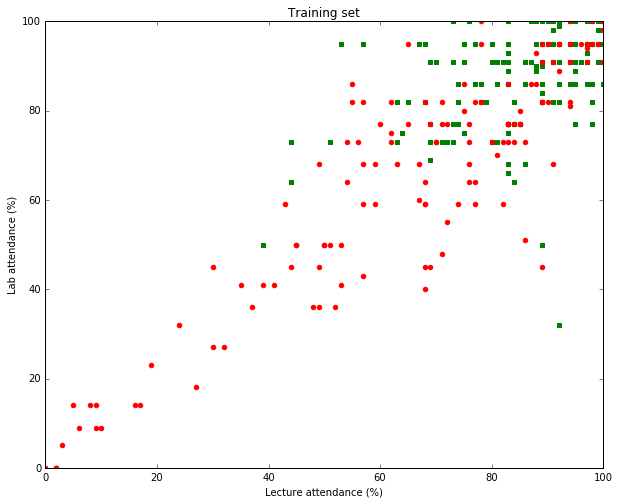

In [5]:
# Plot the data
fig = plt.figure(figsize=(10,8))
plt.title("Training set")
plt.scatter(lects[y==0], labs[y==0], color = "green", marker="s")
plt.scatter(lects[y==1], labs[y==1], color = "red", marker="o")
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Lab attendance (%)")
plt.ylim(0, 100)
plt.show()

<ul>
    <li>A linear model will be a straight line through this data</li>
    <li>If it is possible to find a line that separates the data (only positive examples on one side, only negative
        examples on the other), we say the dataset is <b>linearly separable</b>
        <ul>
            <li>Is the CS1109 dataset linearly separable?</li>
        </ul>
    </li>
    <li>This generalizes from straight lines to planes and hyperplanes in the case of more features</li>
</ul>

<h1>Logistic Regression</h1>
<ul>
    <li>Despite its name, <b>logistic regression</b> is used for <em>classification</em>
        <ul>
            <li>At heart, it predicts a number (and turns it into a probability), hence it is a form 
                of regression
            </li>
            <li>At heart, it build linear models</li>
        </ul>
    </li>
    <li>Let's start with logistic regression for binary classification
        <ul>
            <li>In this case, logistic regression predicts the probability that $\v{x}$ belongs to
                the positive class
            </li>
        </ul>
    </li>
    <li>This is what logistic regression does:
    $$\hat{y} = \left\{ \begin{array}{rl} 
        0 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) <  0.5 \\
        1 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) \geq 0.5
                        \end{array} \right.
    $$
    where
    $$Prob(\hat{y} = 1\, |\, \v{x}) = \sigma(\v{x}\v{\beta})$$
    where
    $$\sigma(z) = \frac{1}{1 + \exp(-z)}$$
    and 
    $\v{x}\v{\beta}$
    is familiar from linear regression (and assumes that $\v{x}$ has an extra 'feature',
    $x_0 = 1$)
    </li>
    <li>We'll study this bit by bit</li>
</ul>

<h1>Logistic Regression Explained</h1>
<ul>
    <li>In Linear Regression, each hypothesis $h_{\v{\beta}}$ was of the form 
        $$\begin{array}{rl}
            h_{\v{x}}(\v{\beta}) & = \v{\beta}_0 + \v{\beta}_1\v{x}_1 + \v{\beta}_2\v{x}_2 + \ldots + \v{\beta}_n\v{x}_n \\
                                 & = \v{x}\v{\beta}
          \end{array}
    $$
        where $\v{x}$ is a row vector with $n+1$ elements (with $x_0 = 1$), and $\v{\beta}$ is a (column)
        vector of coefficients
    </li>
    <li>Why can't we just use this directly to predict probabilities?
        <ul>
            <li>To help you answer, here is one hypothesis $h_{\v{\beta}}$ for the CS1109 dataset
                (using just one of its features, $\mathit{lab}$, for easy visualization)
            </li>
        </ul>
    </li>
</ul>

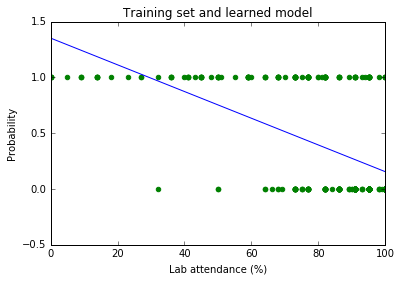

In [6]:
df = pd.read_csv("datasets/dataset_cs1109.csv")

X = df[["lab"]].values
y = df["outcome"].values

linreg = LinearRegression()
linreg.fit(X, y)

xvals = np.array([[0], [100]])
yvals = linreg.predict(xvals)

fig = plt.figure()
plt.title("Training set and learned model")
plt.scatter(X, y, color = "green")
plt.plot(xvals, yvals, color = "blue")
plt.xlabel("Lab attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Probability")
plt.ylim(-0.5, 1.5)
plt.show()

<h1>The Logistic Function</h1>
<ul>
    <li>To 'squash' the values of $\v{x}{\v{\beta}}$ to $[0,1]$ so we can treat them as
        probabilities:
        $$h_{\v{\beta}} = \sigma(\v{x}{\v{\beta}})$$
        where $\sigma$ is the <b>logistic function</b> (also called the 'logit'):
        $$\sigma(z) = \frac{1}{1 + \exp(-z)}$$
    </li>
    <li>The logistic function is a <b>sigmoid function</b> (i.e. S-shaped):
    </li>
</ul>

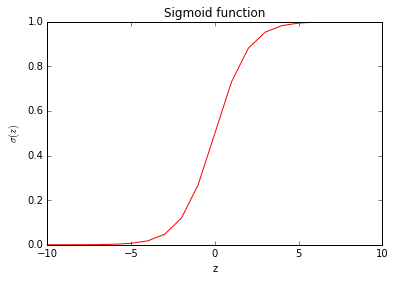

In [7]:
def sigma(z):
    return 1 / (1 + exp(-z))

fig = plt.figure()
plt.title("Sigmoid function")
xvals = np.linspace(-10, 10, 21)
plt.plot(xvals, [sigma(xval) for xval in xvals], color = "red")
plt.xlabel("z")
plt.xlim(-10, 10)
plt.ylabel("$\sigma(z)$")
plt.ylim(0.0, 1.0)
plt.show()

<ul>
    <li>A minor point: the logistic function asymptotically approaches 0 and 1
        <ul>
            <li>So, in fact it values are in $(0,1)$ and not $[0,1]$</li>
        </ul>
    </li>
</ul>

<h1>Logistic Regression Explained</h1>
<ul>
    <li>The hypotheses that logistic regression learns, 
        $h_{\v{\beta}} = \sigma(\v{x}\v{\beta})$, output numbers between 0 and 1
    </li>
    <li>We interpret these numbers as probabilities: the probability that $\v{x}$ belongs to the positive class
        $$Prob(\hat{y} = 1\, |\, \v{x}) = \sigma(\v{x}\v{\beta})$$
    </li>
    <li>Then, to make this a classifier (so it outputs one of the two class labels), we threshold:
        $$\hat{y} = \left\{
           \begin{array}{rl}
           0 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) < 0.5 \\
           1 & \mbox{if } Prob(\hat{y} = 1\, |\, \v{x}) \geq 0.5
           \end{array} \right.
        $$
    </li>
</ul>

<h1>Decision Boundary</h1>
<ul>
    <li>The examples for which logistic regression predicts probabilities of 0.5,
        $Prob(\hat{y} = 1\, |\, \v{x}) = 0.5)$, lie on what is called the <b>decision boundary</b>
    </li>
    <li>Look back at the graph of the logistic function (sigmoid)
        <ul>
            <li>When does the logistic function produce an output of 0.5?</li>
        </ul>
    </li>
    <li>It follows that the decision boundary are examples where
        $$\v{x}{\v{\beta}} = 0$$
    </li>
    <li>Hence, the decision boundary is linear (straight line/plane/hyperplane)</li>
    <li>Examples on or above the boundary are predicted to be in the positive class</li>
</ul>

<h1>Example</h1>
<ul>
    <li>Again, we could ask an expert for a model, e.g. Derek's model might be $\beta = \cv{3200\\-40\\-40\\0}$
    </li>
    <li>I.e. $Prob(\hat{\v{y}} = 1\, |\, \v{x}) = 
        \sigma(3200 - 40\times\mathit{lect} - 40\times\mathit{lab} + 0 \times\mathit{cao})$
    </li>
    <li>So what does Derek's model predict for Craig, who attended 60% of lectures, 25% of labs and has 500 CAO points, $\v{x} = \rv{1, 60, 25, 500}$?
        <ul>
            <li>Compute $\v{x}\v{\beta}$: $\rv{1, 60, 25, 500}\cv{3200\\-40\\-40\\0} = -200$</li>
            <li>Compute its logistic: $\sigma(-200) = \frac{1}{1 + \exp(\,-\,-200)} = 1.38 \times 10^{-87}$
                <ul>
                    <li>What does this mean?</li>
                </ul>
            </li>
            <li>Threshold: Since $1.38 \times 10^{-87} < 0.5$, Derek's model predicts that Craig passes</li>
        </ul>
    </li>
    <li>And we can plot the decision boundary for Derek's model $3200 - 40\times\mathit{lect} - 40\times\mathit{lab} + 0 \times\mathit{cao} = 0$ (but we won't plot CAO):
    </li>
</ul>

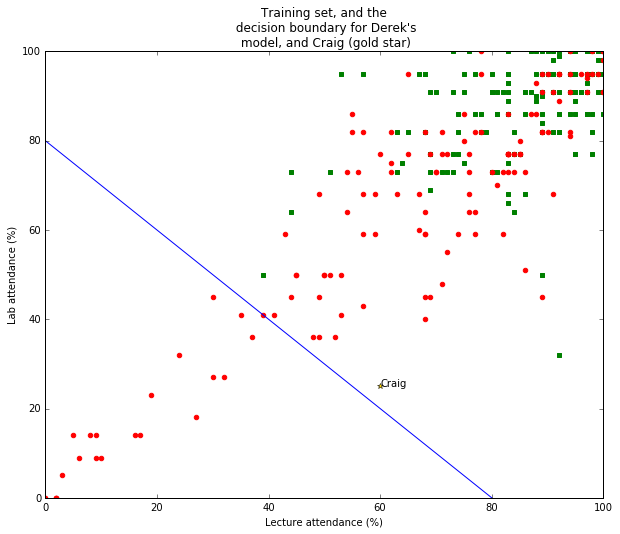

In [8]:
def boundary_Derek(lect):
    return 80 - lect

# Plot the data
fig = plt.figure(figsize=(10,8))
plt.title("Training set, and the\n decision boundary for Derek's\n model, and Craig (gold star)")
plt.scatter(lects[y==0], labs[y==0], color = "green", marker="s")
plt.scatter(lects[y==1], labs[y==1], color = "red", marker="o")
xvals = np.linspace(0, 100, 2)
plt.plot(xvals, boundary_Derek(xvals))
plt.plot([60], [25], color="gold", marker="*")
plt.annotate("Craig", xy = (60, 25), xytext = (0, 0), textcoords = "offset points")
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Lab attendance (%)")
plt.ylim(0, 100)
plt.show()

<ul>
    <li>What's your opinion of Derek's model?</li>
</ul>

<h1>The Loss Function</h1>
<ul>
    <li>The logistic regression learning algorithm will take a labeled dataset and try to find good values
        for $\v{\beta}$
    </li>
    <li>It needs a loss function, which penalizes $h_{\v{\beta}}$ if 
        <ul>
            <li>it outputs high probabilities for negative examples</li>
            <li>it outputs low probabilities for positive examples</li>
        </ul>
    </li>
    <li>The negative of the logarithm of a number grows large when the number approaches zero:
    </li>
</ul>

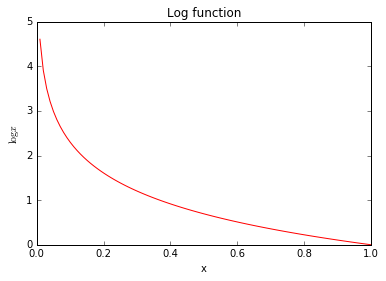

In [9]:
fig = plt.figure()
plt.title("Log function")
xvals = np.linspace(0.01, 1, 99)
plt.plot(xvals, [-log(xval) for xval in xvals], color = "red")
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("$\log x$")
plt.show()

<ul>
    <li>We can use this in a loss function</li>
</ul>

<h1>The Loss Function, continued</h1>
<ul>
    <li>Consider a single training example $\v{x}$ whose actual class $y = 1$
    <li>We want $h_{\v{\beta}}(\v{x})$ to be high
        <ul>
            <li>Why?</li>
        </ul>
    </li>
    <li>So $-\log(h_{\v{\beta}}(\v{x}))$ is a useful loss function
        <ul>
            <li>Why?</li>
        </ul>
    </li>
</ul>   

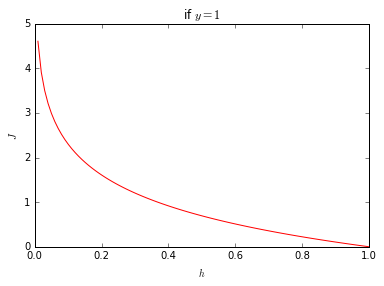

In [10]:
fig = plt.figure()
plt.title("if $y = 1$")
xvals = np.linspace(0.01, 1, 99)
plt.plot(xvals, [-log(xval) for xval in xvals], color = "red")
plt.xlabel("$h$")
plt.xlim(0, 1)
plt.ylabel("$J$")
plt.show()

<h1>The Loss Function, continued</h1>
<ul>
    <li>Consider a single training example $\v{x}$ whose actual class $y = 0$
    <li>We want $h_{\v{\beta}}(\v{x})$ to be low
        <ul>
            <li>Why?</li>
        </ul>
    </li>
    <li>So $-\log(1- (h_{\v{\beta}}(\v{x})))$ is a useful loss function
        <ul>
            <li>Why?</li>
        </ul>
    </li>
</ul>   

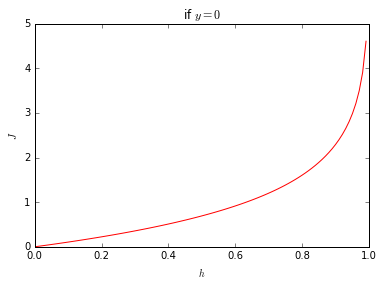

In [11]:
fig = plt.figure()
plt.title("if $y = 0$")
plt.xlabel("$h$")
plt.xlim(0, 1)
plt.ylabel("$J$")
xvals = np.linspace(0, 0.99, 99)
plt.plot(xvals, [-log(1 - xval) for xval in xvals], color = "red")
plt.show()

<h1>The Loss Function, continued</h1>
<ul>
    <li>In summary, for a given example $\v{x}$, we propose the following as the loss function
        $$\left\{ \begin{array}{rl}
                  -\log(h_{\v{\beta}}(\v{x})) & \mbox{if } y = 1 \\
                  -\log(1-h_{\v{\beta}}(\v{x})) & \mbox{if } y = 0
                  \end{array}
          \right.
        $$
        Or, equivalently:
        $$-\v{y}^{(i)}\log(h_{\v{\beta}}(\v{x})) + -(1 - \v{y}^{(i)})\log(1-h_{\v{\beta}}(\v{x}))$$
        Or
        $$-[\v{y}^{(i)}\log(h_{\v{\beta}}(\v{x})) + (1 - \v{y}^{(i)})\log(1-h_{\v{\beta}}(\v{x}))]$$
    </li>
    <li>The overall loss function, $J$, is simply the average of this over all the training examples:
        $$J(\v{X}, \v{y}, \v{\beta}) = - \frac{1}{m}\sum_{i=1}^m[\v{y}^{(i)}\log(h_{\v{\beta}}(\v{x}^{(i)})) +
                                                (1 - \v{y}^{(i)})\log(1 - h_{\v{\beta}}(\v{x}^{(i)}))]$$
    </li>
</ul>

<h1>Example</h1>

In [12]:
df = pd.read_csv("datasets/dataset_cs1109.csv")

y = df["outcome"].values

In [13]:
# The features we want to select
features = ["lect", "lab", "cao"]

# Create the pipeline
pipeline = Pipeline([
        ("selector", DataFrameSelector(features, "float64")),
        ("scaler", StandardScaler()),
        ("estimator", LogisticRegression())
    ])

In [14]:
# Fit the linear model
pipeline.fit(df, y)

Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['lect', 'lab', 'cao'], dtype='float64')), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

<ul>
    <li>Warning! I trained on the whole dataset &mdash; not our normal practice!</li>
</ul>

In [15]:
# Predict Craig's fate

craig_df = pd.DataFrame([{"lect":60, "lab":25, "cao":500}])
pipeline.predict(craig_df) 

array([1])

<ul>
    <li>He fails!</li>
</ul>

<h1>Multiclass Classification</h1>
<ul>
    <li>Many classifiers can only do binary classification</li>
    <li>How can we use a binary classifier for a multiclass problem? Two methods are common:
        <ul>
            <li>One-versus-Rest; and </li>
            <li>One-versus-One.</li>
        </ul>
    </li>
</ul>

<h2>One-versus-Rest</h2>
<ul>
    <li><b>One-versus-Rest</b> (also called 'one-versus-all')
        involves training $|C|$ binary classifiers, one per class
        <ul style="background: lightgray">
            <li>
                <b>for each</b> class $c \in C$
                <ul>
                    <li>
                        create a copy of the training set in which you replace examples 
                        $\Tuple{\v{x}, c}$ by $\Tuple{\v{x}, 1}$ and examples $\Tuple{\v{x}, c'}$ 
                        where $c' \neq c$ by $\Tuple{\v{x}, 0}$
                    </li>
                    <li>
                        train a binary classifier $h^c$ on this modified training set
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>After all these classifiers have been trained, to classify $\v{x}$, we run all the classifiers 
        $h^c$ for each $c \in C$
        <ul>
            The predicted class of $\v{x}$ is the class $c$ whose classifier $h^c$ predicts 1 with 
            highest probability
        </ul>
    </li>
    <li>How many classifiers would we end up building for a dataset where there are three classes?</li>
</ul>

<h2>One-versus-One</h2>
<ul>
    <li>In <b>One-versus-One</b> (also called 'pairwise classification'), 
        we build a classifier <em>for every pair</em> of classes using 
        only the training data for those two classes
    </li>
    <li>After all these classifiers have been trained, when we want to classify $\v{x}$, we run all 
        the classifiers and, for each class $c \in C$, we count how many of the classifiers predict 
        that class
        <ul>
            <li>The predicted class of $\v{x}$ is the one that is predicted most often
            </li>
        </ul>
    </li>
    <li>One-versus-One's advantage over One-versus-Rest is that the individual classifiers do not need 
        to be classifiers that produce probabilities
    </li>
    <li>Its disadvantage is the number of individual classifiers it must train
        <ul>
            <li>How many for a dataset that has three classes?</li>
            <li>In terms of $|C|$, how many in general?</li>
            <li>What offsets this, so that in practice it may be 
                quite feasible?
            </li>
        </ul>
    </li>
</ul>

<h1>Multinomial Logistic Regression</h1>
<ul>
    <li>Logistic Regression is one of the few classifiers that can directly handle multiclass
        classification
    </li>
    <li>We must modify how the classifier works and the loss function for training
    </li>
    <li>Now, instead of one vector of coefficients, $\v{\beta}$, the classifier has one <em>per class</em>,
        $\v{\beta}_c$  for each $c \in C$
    </li>
    <li>Hence, instead of computing one value, $\v{x}{\v{\beta}}$, it computes one per class,
        $\v{x}\v{\beta}_c$ for each $c \in C$
    </li>
    <li>Now, 'squashing' is more complicated:
        <ul>
            <li>Not only must each of these values be squashed to $[0,1]$</li>
            <li>But they must also sum to 1</li>
        </ul>
        So we do not use the logistic function
    </li>
    <li>We use the <b>softmax function</b> (but still often designated by $\sigma$):
        $$Prob(\hat{y} = c\, |\, \v{x}) = \sigma(\v{x}\v{\beta}_c) = \frac{\exp(\v{x}\v{\beta}_c)}{\sum_{c' \in C} \exp(\v{x}\v{\beta}_{c'})}$$
    </li>
    <li>(BTW, if we put all the different $\v{\beta}_c$ into a single matrix $\v{B}$,
        then we can have a vectorized implementation  of this)
    </li>
    <li>Finally, there is no thresholding this time: the classifier simply predicts the class with the
        highest estimated probability
    </li>
    <li>If you like symbols, here it is all in one line:
        $$\hat{y} = \argmax_{c \in C}(\sigma(\v{x}\v{\beta}_c))$$
    </li>
</ul>

<h1>Multinomial Logistic Regression</h1>
<ul>
    <li>So how does logistic regression learn all these different $\v{\beta}_c$?</li>
    <li>We need a new loss function: the <b>cross entropy loss function</b>
        $$J(\v{X}, \v{y}, \v{B}) = -\frac{1}{m}\sum_{i=1}^m\sum_{c \in C}I(\v{y}^{(i)} = c)\log(\sigma(\v{x}^{(i)}\v{\beta}_c))$$
        where $I(p)$ is the indicator function that outputs 1 if predicate $p$ is true and zero otherwise
     </li>
     <li>The easiest way to get some grasp of this is to relaise that when there are just two classes, it is
         equivalent to the loss function we used earlier
    </li>
</ul>

<h2>Multiclass Logistic Regression in scikit-learn</h2>
<ul>
    <li>In scikit-learn, all binary classifiers can also be used for multiclass classification
        <ul>
            <li>By default, when needed, they use one-versus-rest &hellip; automatically</li>
        </ul>
    </li>
    <li>This is true of <code>Logistic Regression</code> too
    </li>
    <li>But we can ask for multinomial regression using the cross-entropy loss function:
        <ul>
            <li>set the <code>multi_class</code> parameter to <code>"multinomial"</code>
                (default is <code>multi_class="ovr"</code>)
            </li>
            <li>but we must also set the <code>solver</code> parameter to one of
                <code>"lbfgs"</code>, <code>"sag"</code> or <code>"newton-cg"</code>
            </li>
        </ul>
    </li>
</ul>

<h1>Which is better?</h1>
<ul>
    <li>Sometimes, even when you have a classifier, such as Logistic Regression, that can directly 
        handle multiclass classification, using it in a One-versus-One fashion can be more accurate! 
        <ul>
            <li>This is because it is like an 'ensemble' learning method,
                which we will discuss properly in a later lecture in <i>CS4619</i>
            </li>
        </ul>
    </li>
</ul>